In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import seaborn as sns

In [2]:
data = fetch_california_housing(as_frame=True)
df = data.frame

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Weak (And Fast) Model

When we use simple, linear models there is a lot we can do with the data to better prepare it for the model. For example, transformations usually work quite well.

In [4]:
def model(df):
    
    X = df.drop(columns='MedHouseVal')  # Features
    y = df['MedHouseVal']  # Target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.2f}")

In [5]:
def return_df():
    data = fetch_california_housing(as_frame=True)
    df = data.frame
    return df

In [6]:
def plot_column_skewness(column):
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Skewness of {column}: {df[column].skew():.2f}', fontsize=15)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [13]:
def detect_outliers():
    outlier_dict = {}
    for column in df.select_dtypes(include=[float, int]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Detect outliers outside 1.5 * IQR
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | 
                        (df[column] > (Q3 + 1.5 * IQR))]
        outlier_dict[column] = outliers.shape[0] / len(df)
        
    return pd.DataFrame(list(outlier_dict.items()), columns=['Feature', 'Outlier_Count'])

outliers_df = detect_outliers()

outliers_df

,Feature,Outlier_Count
0,MedInc,0.032994
1,HouseAge,0.000000
2,AveRooms,0.031056
3,AveBedrms,0.066376
4,Population,0.057946
5,AveOccup,0.024758
6,Latitude,0.000000
7,Longitude,0.000000
8,MedHouseVal,0.051890


In [59]:
df[df.columns].skew()

MedInc          1.646657
HouseAge        0.060331
AveRooms       20.697869
AveBedrms      31.316956
Population      4.935858
AveOccup       97.639561
Latitude        0.465953
Longitude      -0.297801
MedHouseVal     0.977763
dtype: float64

## Leves of Skewness

This isnt a science, but Id say something between -.05 and + 0.5 has low skewness.

-1 to 1 is medium.

Less than -1 or more than 1 is pretty high.

If the data is skewed, you should generally consider transforming it.

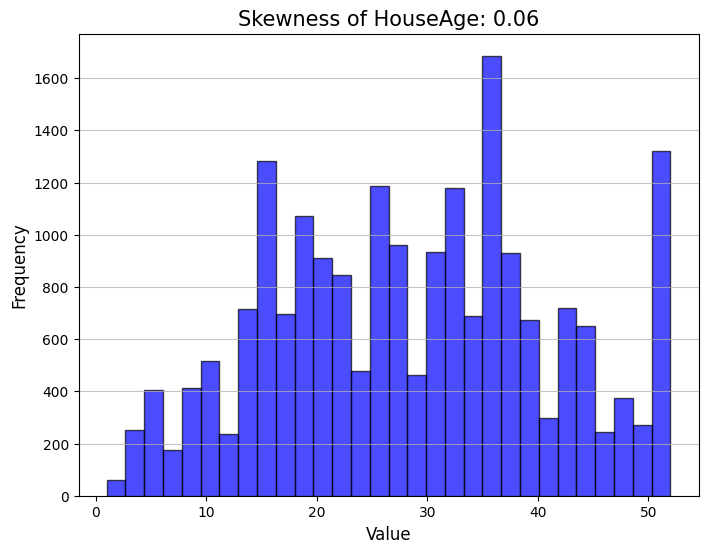

In [60]:
plot_column_skewness('HouseAge')

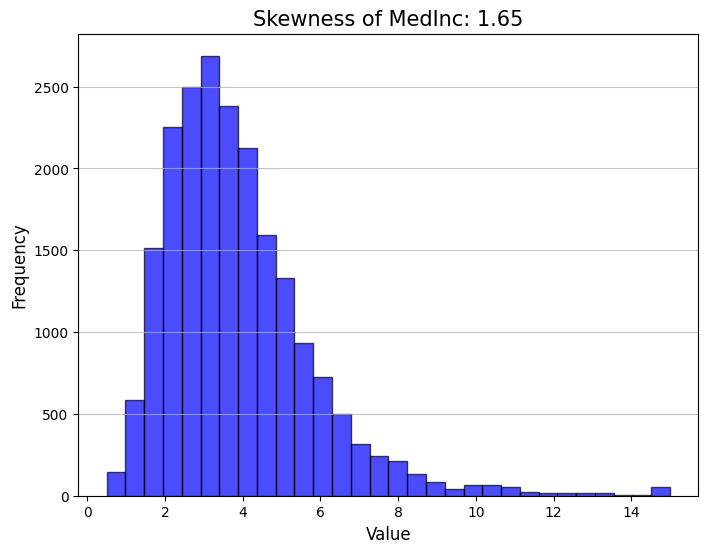

In [61]:
plot_column_skewness('MedInc')

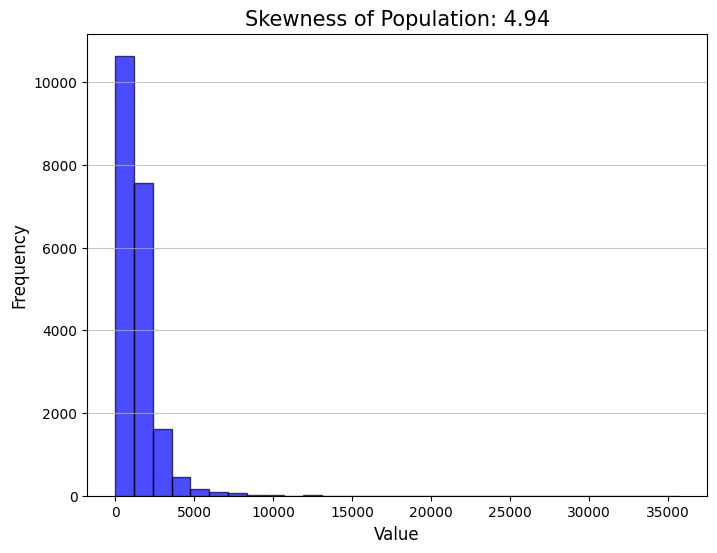

In [62]:
plot_column_skewness('Population')

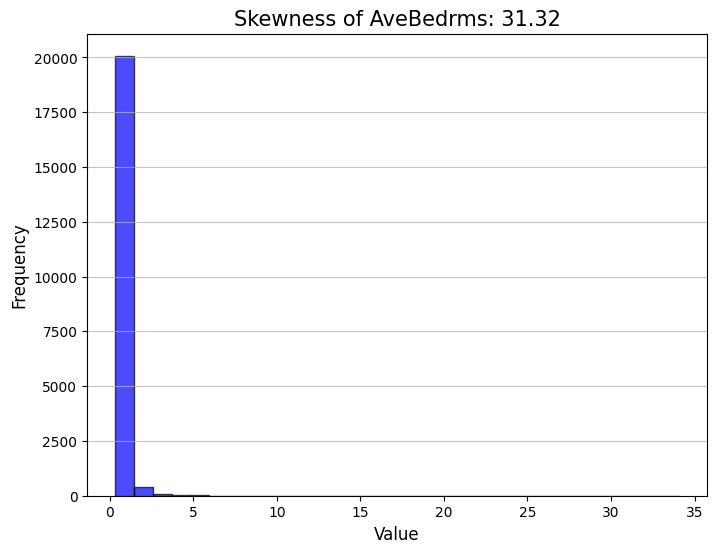

In [63]:
plot_column_skewness('AveBedrms')

## Which Transformation Should You Use

1. Logarithmic Transformation

    When to use:

    Works well when data has positive skew with large values.
    
    How it helps: Compresses the range of data, reducing the impact of extreme values.

In [64]:
# df['Transformed_Column'] = np.log1p(df['Original_Column'])  # log(1 + x) to handle 0 values

2. Square Root Transformation

    When to use:
    
    Works for moderately positive skew.
    
    How it helps:
    
    Reduces larger values but not as aggressively as a log transformation.


In [65]:
# df['Transformed_Column'] = np.sqrt(df['Original_Column'])

3. Box-Cox Transformation

    When to use:
    
    If data is positive and strictly greater than 0.
    
    How it helps:
    
    Box-Cox finds the best exponent (λ) to make data more normal.

In [66]:
from scipy.stats import boxcox

# df['Transformed_Column'], _ = boxcox(df['Original_Column'] + 1)  # Add 1 to avoid 0 values

4. Reciprocal Transformation

    When to use:
    
    Works for data with extremely high skewness.
    
    How it helps:
    
    Inverts large values to become small and vice versa.

In [67]:
# df['Transformed_Column'] = 1 / (df['Original_Column'] + 1) # Add 1 to avoid division by zero

5. Yeo-Johnson Transformation

    When to use:
    
    When data contains zero or negative values.
    
    How it helps:
    
    Similar to Box-Cox but supports non-positive data.


In [68]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
# df['Transformed_Column'] = pt.fit_transform(df[['Original_Column']])

6. Clipping or Winsorizing (Handling Outliers)

    When to use:
    
    If the skewness is due to extreme outliers.
    
    How it helps:
    
    Limits extreme values to reduce skewness.

In [69]:
from scipy.stats import mstats

# df['Transformed_Column'] = mstats.winsorize(df['Original_Column'], limits=[0.05, 0.05])

In [7]:
def perform_reciprocal_transformation(cols: list):
    
    for col in cols:
                
        df[col] = 1 / (df[col] + 1)

In [14]:
df = return_df()

In [19]:
%time model(df)

Mean Squared Error (MSE): 0.53
R² Score: 0.60
CPU times: user 27 ms, sys: 89.2 ms, total: 116 ms
Wall time: 32 ms


In [20]:
detect_outliers()

,Feature,Outlier_Count
0,MedInc,0.032994
1,HouseAge,0.000000
2,AveRooms,0.024758
3,AveBedrms,0.068992
4,Population,0.057946
5,AveOccup,0.034448
6,Latitude,0.000000
7,Longitude,0.000000
8,MedHouseVal,0.051890


In [21]:
cols_for_transformation = ['AveRooms', 'AveBedrms', 'AveOccup']
perform_reciprocal_transformation(cols_for_transformation)

In [22]:
detect_outliers()

,Feature,Outlier_Count
0,MedInc,0.032994
1,HouseAge,0.000000
2,AveRooms,0.031056
3,AveBedrms,0.066376
4,Population,0.057946
5,AveOccup,0.024758
6,Latitude,0.000000
7,Longitude,0.000000
8,MedHouseVal,0.051890


In [23]:
model(df)

Mean Squared Error (MSE): 0.43
R² Score: 0.67


In [201]:
df[df.columns].skew()

MedInc         1.646657
HouseAge       0.060331
AveRooms       0.975406
AveBedrms     -4.592451
Population     4.935858
AveOccup       0.206654
Latitude       0.465953
Longitude     -0.297801
MedHouseVal    0.977763
dtype: float64

# Stronge Model

When you're using strong models, like XGBoost, you should focus much less on transformation and much more on substantial problems in the data such as outliers, or actually creating new features. 

As XGBoost is pretty powerful, it does the rest itself.

In [30]:
df = return_df()

In [31]:
def model_xgb():
    
    X = df.drop(columns='MedHouseVal') 
    y = df['MedHouseVal']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    
    return model

In [32]:
model_xgb()

Mean Squared Error: 0.22
R^2 Score: 0.83


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [302]:
def detect_outliers():
    outlier_dict = {}
    for column in df.select_dtypes(include=[float, int]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Detect outliers outside 1.5 * IQR
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | 
                        (df[column] > (Q3 + 1.5 * IQR))]
        outlier_dict[column] = outliers.shape[0] / len(df)
        
    return pd.DataFrame(list(outlier_dict.items()), columns=['Feature', 'Outlier_Count'])

outliers_df = detect_outliers()

outliers_df

,Feature,Outlier_Count
0,MedInc,0.032994
1,HouseAge,0.000000
2,AveRooms,0.024758
3,AveBedrms,0.068992
4,Population,0.057946
5,AveOccup,0.034448
6,Latitude,0.000000
7,Longitude,0.000000
8,MedHouseVal,0.051890


In [304]:
df = return_df()

In [33]:
def cap_outliers(cols: list):
    
    for col in cols:
        
    
        Q1 = df[col].quantile(0.01)
        Q99 = df[col].quantile(0.99)

        df[col] = df[col].clip(Q1, Q99)

In [34]:
cap_outliers(['AveBedrms', 'Population'])

By default, the xgboost feature importance shows weight, meaning how many times the feature was used for splitting.

Mean Squared Error: 0.22
R^2 Score: 0.83


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

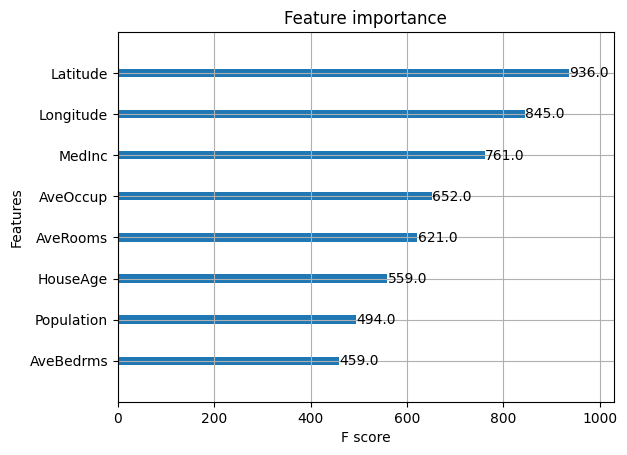

In [35]:
xgb_mdl = model_xgb()
xgb.plot_importance(xgb_mdl)

In [269]:
feature_importance = xgb_mdl.get_booster().get_score(importance_type='weight')

sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

In [270]:
sorted_feature_importance

{'Longitude': 828.0,
 'Latitude': 809.0,
 'MedInc': 698.0,
 'AveOccup': 658.0,
 'Population': 507.0,
 'HouseAge': 502.0,
 'AveRooms': 501.0,
 'new_feature': 477.0,
 'AveBedrms': 382.0}

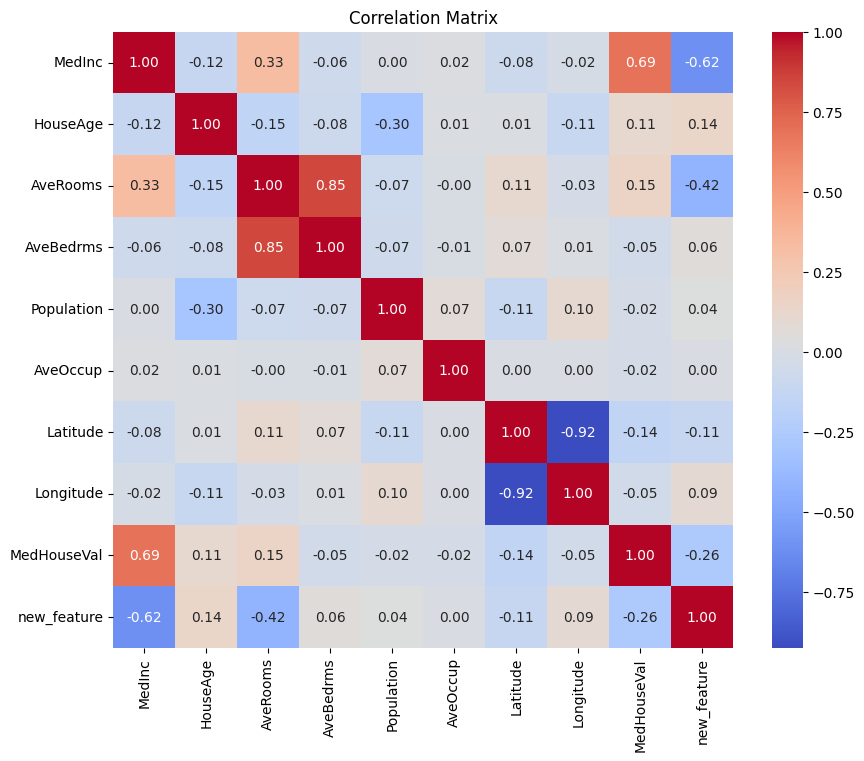

In [284]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()  

## Creating a New Feature

How should you combine 2 features? multiplying? dividing?

Are both features working together to amplify the target?
→ Use multiplication (interaction effect).
Example: Speed × Strength may contribute to a player’s explosiveness.

Does the relationship between the two features matter more than their individual values?
→ Use division (proportional effect).
Example: Points / Games Played gives a better sense of consistency than total points alone.

Are you trying to measure how effectively something is done?
→ Use division (e.g., goals per shot or points per game).

In [273]:
df = return_df()

In [274]:
df['new_feature'] = df['AveBedrms'] / df['AveRooms']

In [275]:
model_xgb()

Mean Squared Error: 0.22
R^2 Score: 0.83


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

### Squaring Features

What about squaring features? How should you think about it?

- Check for non-linear relationships with the target (curved patterns).
- Look for high correlations with the target (|correlation| > 0.5).
- Square interacting features to capture complex relationships.
- Use cross-validation to confirm that squaring improves model performance.
- Avoid squaring categorical features or features with little predictive power.

In [296]:
def pairwise_and_group_correlations(df, target_column='MedHouseVal'):
    features = df.drop(columns=[target_column]).columns
    results = []

    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            if j > i:  # Avoid duplicate pairs and self-correlation
                # Calculate individual correlations
                corr1 = df[feature1].corr(df[target_column])
                corr2 = df[feature2].corr(df[target_column])
                corr_pair = df[feature1].corr(df[feature2])

                # Create a new feature (product) to measure group effect
                new_feature = df[feature1] * df[feature2]
                group_corr = new_feature.corr(df[target_column])

                # Store the results
                results.append({
                    'Feature1': feature1,
                    'Feature2': feature2,
                    'Group Corr(Feature1 * Feature2, Target)': group_corr
                })

    return pd.DataFrame(results)

In [297]:
correlation_results = pairwise_and_group_correlations(df)
print(correlation_results.head(10))

   Feature1     Feature2  Group Corr(Feature1 * Feature2, Target)
0    MedInc     HouseAge                                 0.589142
1    MedInc     AveRooms                                 0.555438
2    MedInc    AveBedrms                                 0.510058
3    MedInc   Population                                 0.276269
4    MedInc     AveOccup                                 0.028285
5    MedInc     Latitude                                 0.674713
6    MedInc    Longitude                                -0.689376
7    MedInc  new_feature                                -0.623546
8  HouseAge     AveRooms                                 0.210048
9  HouseAge    AveBedrms                                 0.053226


In [38]:
df = return_df()

In [39]:
df['income_and_houseAge'] = df['MedInc'] / df['HouseAge']

df['MedInc_sq'] = df['MedInc'] ** 2    

In [40]:
model_xgb()

Mean Squared Error: 0.23
R^2 Score: 0.83


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)